The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
x0 =  6.101404666900635


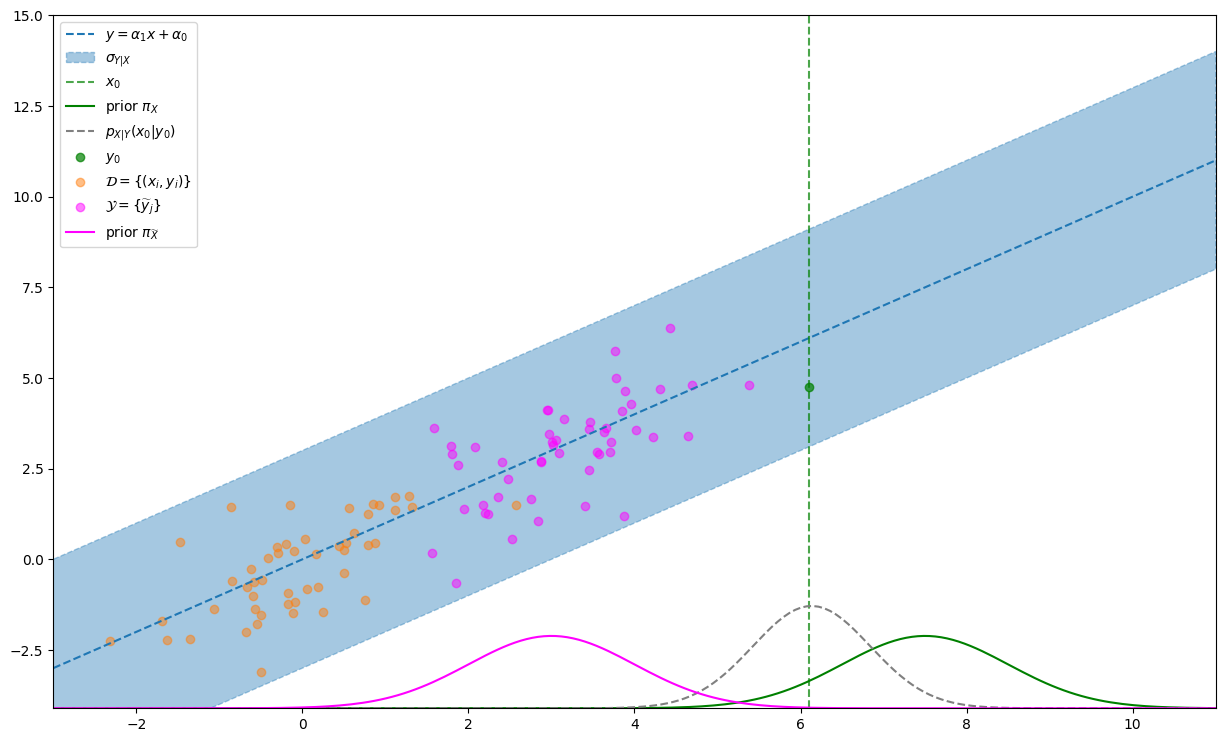

In [28]:
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from regressor import *
from utils import *
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
beta0 =torch.distributions.MultivariateNormal(mu_beta, Sigma_beta).sample()
beta0 = torch.tensor([1.,0.])

mu_X =torch.tensor(7.5)
sigma2_X =torch.tensor(1)
x0 =  torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).sample()

prior_dataset = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1))
n_D = 50
DX =prior_dataset.sample([n_D])

sigma2_simulateur = torch.tensor(1)
f = lambda x: beta0[0]*x + beta0[1] 
simulateur= lambda x: f(x) + torch.randn(x.shape[0])*torch.sqrt(sigma20)
DY = simulateur(DX)

print('x0 = ',str(x0.item()))
n_y0= 1
y0 = simulateur(x0.repeat(n_y0))


posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X, sigma2_X).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
true_posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))

list_xj = []
list_yj = []
n_unlabeled_obs = 50
n_per_obs = 1
for t in torch.linspace(-10,10,n_unlabeled_obs):
    prior = torch.distributions.Normal(3, 1)
    xj = prior.sample()
    list_xj.append(xj.unsqueeze(0).repeat(n_per_obs))
    yj = simulateur(xj.unsqueeze(0).repeat(n_per_obs))
    list_yj.append(yj.unsqueeze(0))
if n_unlabeled_obs>0:
    Y = torch.cat(list_yj, dim = 0)
    X = torch.cat(list_xj, dim = 0)
else: 
    Y = torch.tensor([])
    X = torch.tensor([])
prior_means = 3*torch.ones(n_unlabeled_obs)
prior_sigma2s = torch.ones(n_unlabeled_obs)

y_min = torch.min(torch.cat([DY, torch.flatten(Y)])-1)

plt.figure(figsize = (15,9))
ax = plt.subplot()
ax.set_xlim(-3,11)
tt = torch.linspace(-3,11,200)
plt.plot(tt.numpy(),f(tt).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
plt.fill_between(tt.numpy(),f(tt).numpy() - 3*torch.sqrt(sigma20).numpy(),f(tt).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.4, label = r'$\sigma_{Y|X}$')
plt.axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
plt.plot(tt, y_min + 5*torch.exp(torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X)).log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_X$')
plt.plot(tt,y_min+5*torch.exp(true_posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')
plt.scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')

#hist = plt.hist(y0.numpy(), orientation ='horizontal', bins = n_y0, density = True,histtype = 'step', bottom = -3.5, label = r'histogramme de $y_0$')
plt.scatter(X,Y,color = 'magenta', alpha = .5, label = r'$\mathcal{Y} = \{\widetilde{y}_j\}$')
plt.plot(tt, y_min + 5*torch.exp(torch.distributions.Normal(3, 1).log_prob(tt.unsqueeze(-1))), color = 'magenta', label=r'prior $\pi_{\widetilde{X}}$')
plt.ylim(y_min,)
plt.legend()
plt.show()

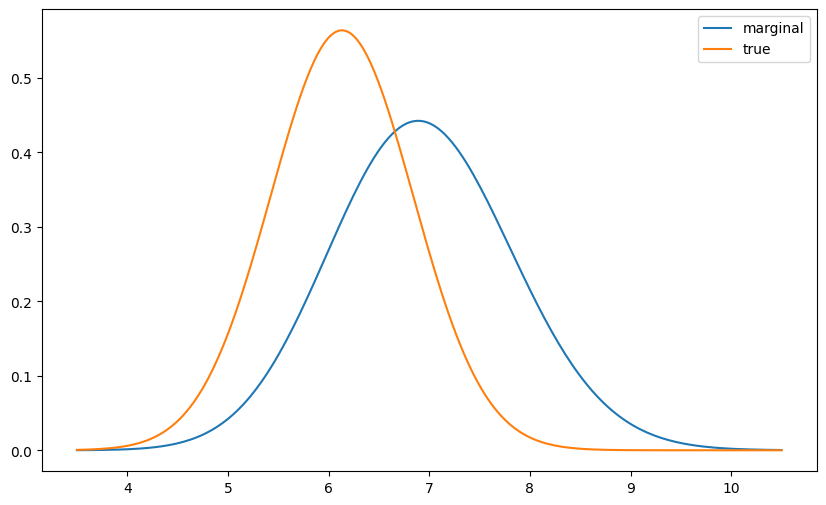

In [29]:
tt_post = torch.linspace(3.5,10.5,200)
blr_ = generative_bayesian_affine_regression_known_variance(sigma20,mu_X, sigma2_X, mu_beta,Sigma_beta)
log_prob = blr_.x0_given_y0_D_marginal_log_posterior(tt_post, y0, DX, DY)
plot_1d_unormalized_values(tt_post,torch.exp(log_prob),show = False, label = 'marginal')
plt.plot(tt_post,torch.exp(true_posterior.log_prob(tt_post)), label = 'true')
plt.legend()
plt.show()

In [30]:
blr = generative_bayesian_affine_regression(mu_X, sigma2_X, mu_beta,Sigma_beta,shape_sigma2, scale_sigma2)
X0_,_,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY,number_steps=5000, verbose = True)
X0,_,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, Y,prior_means, prior_sigma2s, number_steps=5000, verbose = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 96.57it/s]


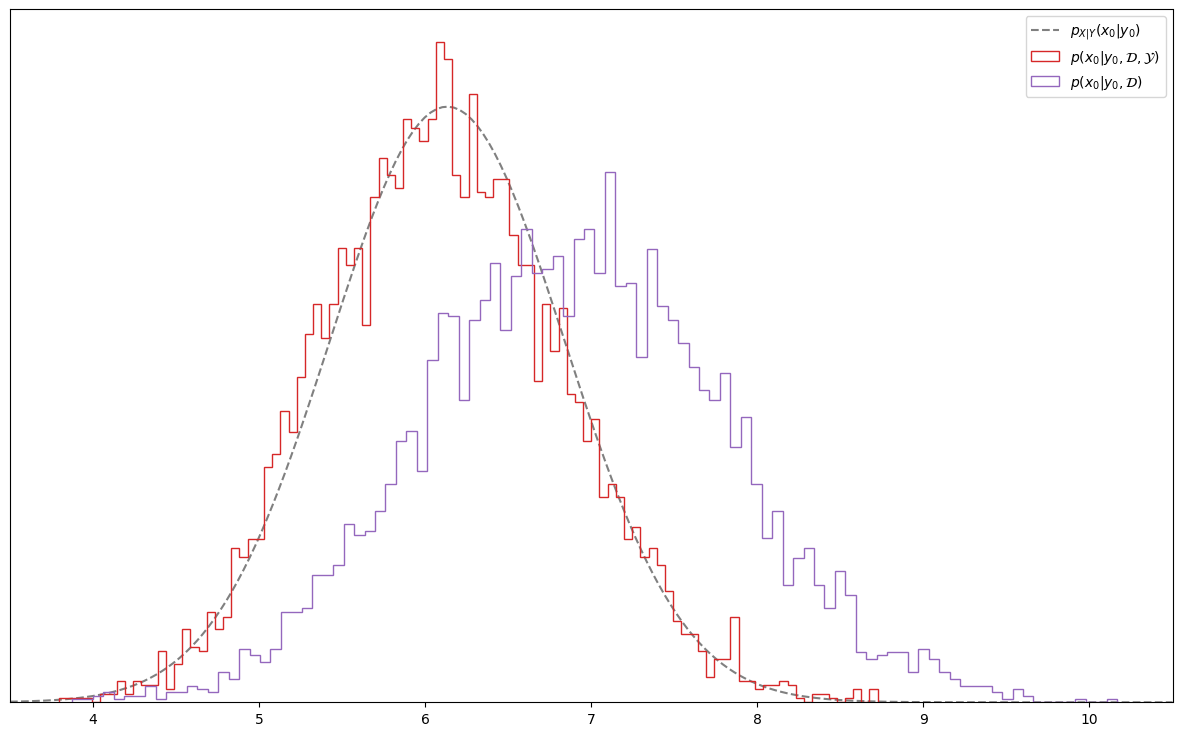

In [31]:
plt.figure(figsize = (15,9))
ax = plt.subplot()
plt.plot(tt_post, torch.exp(true_posterior.log_prob(tt_post)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.hist(X0, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D},\mathcal{Y})$', color = 'C3')
plt.hist(X0_, bins = 100, density = True, histtype = 'step', label= r'$p(x_0|y_0,\mathcal{D})$', color = 'C4')
ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax.set_xlim(3.5,10.5)
plt.legend()
plt.show()

In [32]:
class discriminative_bayesian_affine_regression:
    def __init__(self,mu_beta=torch.zeros(2), Sigma_beta=torch.eye(2), shape_sigma2=torch.tensor(1.),
                 scale_sigma2=torch.tensor(1.)):
        self.mu_beta = mu_beta
        self.Sigma_beta = Sigma_beta
        self.shape_sigma2 = shape_sigma2
        self.scale_sigma2 = scale_sigma2

    def compute_beta_given_sigma2_D_moments(self,sigma2, DX, DY):
        assert DX.shape == DY.shape, 'Mismatch in number samples'
        temp = torch.cat([DY.unsqueeze(-1), torch.ones(DY.shape[0], 1)], dim=-1)
        Sigma_beta_given_D = torch.inverse(temp.T @ temp / sigma2 + torch.inverse(self.Sigma_beta))
        mu_beta_given_D = Sigma_beta_given_D@(DX @ temp / sigma2 + torch.inverse(self.Sigma_beta)@self.mu_beta)
        return mu_beta_given_D, Sigma_beta_given_D

    def compute_x0_given_y0_beta_sigma2_moments(self, y0, beta,sigma2):
        assert y0.shape[0] == 1, 'Discriminative does not support multiple observations'
        mu_x0_given_y0_beta = beta@torch.cat([y0,torch.ones_like(y0)], dim = -1)
        sigma2_x0_given_y0_beta = sigma2
        return mu_x0_given_y0_beta, sigma2_x0_given_y0_beta

    def compute_x0_given_y0_D_moments(self,y0, DX,DY):
        assert y0.shape[0]==1, 'Discriminative does not support multiple observations'
        mu_beta_given_D, sigma2_beta_given_D = self.compute_beta_given_D_moments(DX, DY)
        mu_x0_given_y0_D = mu_beta_given_D@torch.cat([y0,torch.ones_like(y0)], dim = -1)
        sigma2_x0_given_y0_D = torch.cat([y0,torch.ones_like(y0)], dim = -1)@sigma2_beta_given_D@torch.cat([y0,torch.ones_like(y0)], dim = -1) + self.sigma2_simulateur
        return mu_x0_given_y0_D, sigma2_x0_given_y0_D.squeeze(-1)

    def sample_sigma2_given_beta_D_parameters(self, beta, DX, DY):
        assert DX.shape[0] == DY.shape[0], 'Mismatch in number samples'
        temp = torch.cat([DY.unsqueeze(-1), torch.ones(DY.shape[0], 1)], dim=-1)
        shape_N = self.shape_sigma2 + DX.shape[0] / 2
        scale_N = self.scale_sigma2 + torch.sum(torch.square(DX - temp @ beta)) / 2
        estimated_sigma2 = pyro.distributions.InverseGamma(shape_N, scale_N).sample()
        return estimated_sigma2

    def sample_x0_given_y0_D_gibbs(self, y0, DX, DY,number_steps=100, verbose=False):
        assert DX.shape[0] == DY.shape[0], 'mismatch in dataset numbers'
        current_sigma2 = pyro.distributions.InverseGamma(self.shape_sigma2, self.scale_sigma2).sample()
        mean_beta_given_sigma2_D, Sigma_beta_given_sigma2_D = self.compute_beta_given_sigma2_D_moments(current_sigma2, DX, DY)
        current_beta = torch.distributions.MultivariateNormal(mean_beta_given_sigma2_D, Sigma_beta_given_sigma2_D).sample()
        list_x0_gibbs = []
        list_beta_gibbs = []
        list_sigma2_gibbs = []
        DYplus = torch.cat([DY, y0], dim = 0)
        if verbose:
            pbar = tqdm(range(number_steps))
        else:
            pbar = range(number_steps)
        for _ in pbar:
            mean_x0_given_y0_beta_sigma2, sigma2_x0_given_y0_beta_sigma2 = self.compute_x0_given_y0_beta_sigma2_moments(
                y0, current_beta, current_sigma2)
            current_x0 = torch.distributions.Normal(mean_x0_given_y0_beta_sigma2,
                                                    torch.sqrt(sigma2_x0_given_y0_beta_sigma2)).sample()
            DXplus = torch.cat([DX, current_x0.repeat(y0.shape[0])])
            mean_beta_given_Dplus, Sigma_beta_given_Dplus = self.compute_beta_given_sigma2_D_moments(current_sigma2,
                                                                                                     DXplus, DYplus)
            current_beta = torch.distributions.MultivariateNormal(mean_beta_given_Dplus,
                                                                  Sigma_beta_given_Dplus).sample()
            current_sigma2 = self.sample_sigma2_given_beta_D_parameters(current_beta, DXplus, DYplus)
            list_x0_gibbs.append(current_x0)
            list_beta_gibbs.append(current_beta)
            list_sigma2_gibbs.append(current_sigma2)
        return torch.stack(list_x0_gibbs), torch.stack(list_beta_gibbs), torch.stack(list_sigma2_gibbs)
discriminative = discriminative_bayesian_affine_regression(mu_beta,Sigma_beta,shape_sigma2, scale_sigma2)
X0d,beta_dis,sigma2_dis = discriminative.sample_x0_given_y0_D_gibbs(y0, DX, DY, 50000, verbose = True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:40<00:00, 1243.98it/s]


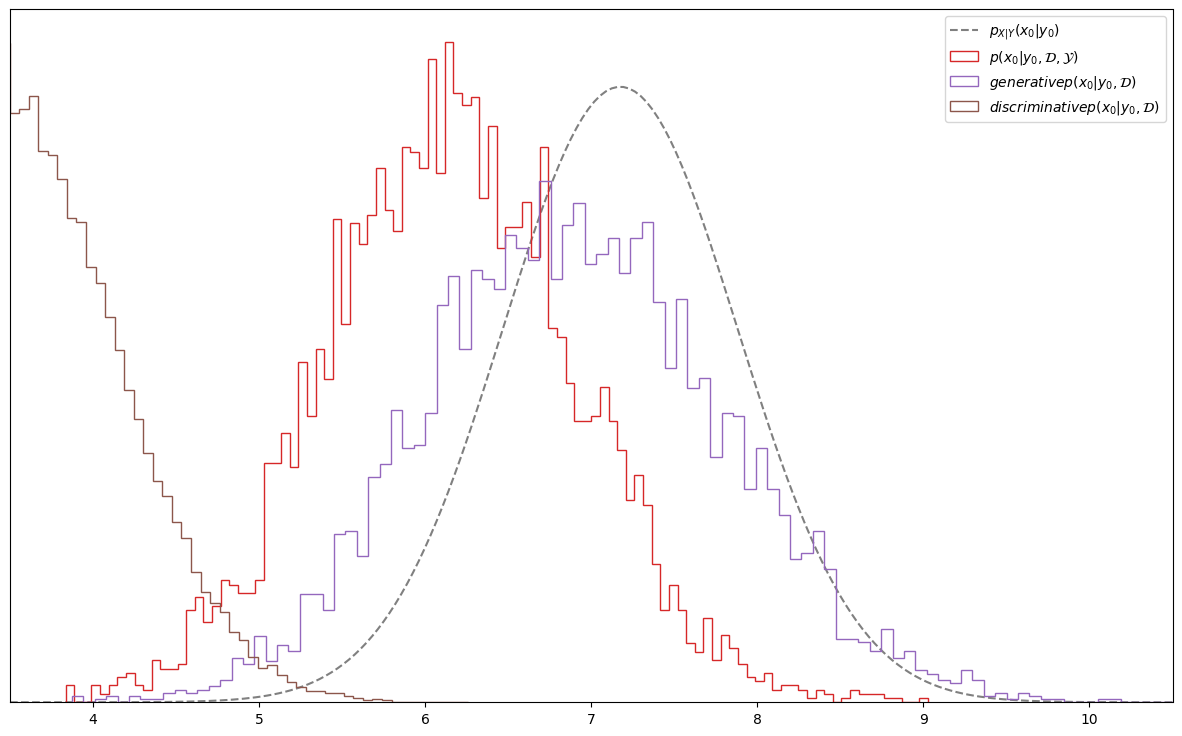

In [25]:
plt.figure(figsize = (15,9))
ax = plt.subplot()
plt.plot(tt_post, torch.exp(true_posterior.log_prob(tt_post)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
plt.hist(X0, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D},\mathcal{Y})$', color = 'C3')
plt.hist(X0_, bins = 100, density = True, histtype = 'step', label= r'$generative p(x_0|y_0,\mathcal{D})$', color = 'C4')
plt.hist(X0d, bins = 100, density = True, histtype = 'step', label= r'$discriminative p(x_0|y_0,\mathcal{D})$', color = 'C5')
ax.tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax.set_xlim(3.5,10.5)
plt.legend()
plt.show()

In [26]:
beta = beta_dis[-1]
sigma2 = sigma2_dis[-1]

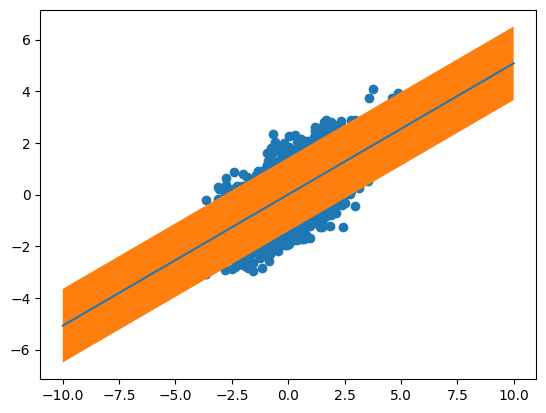

In [27]:
plt.scatter(DY,DX)
tt = torch.linspace(-10,10, 200)
plt.plot(tt, tt*beta[0] + beta[1])
plt.fill_between(tt, tt*beta[0] + beta[1] - 3*sigma2,  tt*beta[0] + beta[1] + 3*sigma2 )